In [46]:
import boto3
import pandas as pd
import numpy as np
import io
import sys
import os
import seaborn as sns
# local libraries
sys.path.append(os.path.abspath(os.path.join(sys.path[0], '..', 'src', 'lib')))
import athena_connect
import market_maker_training

pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
pd.options.mode.chained_assignment = None
%matplotlib inline

In [47]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import datetime
from datetime import timedelta

(datetime.datetime.utcnow() - timedelta(days=10)).strftime("%Y-%m-%d")
#datetime.datetime.utcnow().strftime("%Y-%m-%d")

'2018-06-23'

# "Market Maker" Model Development

In [48]:
def features(feature_minutes_list, trade_window_list=[10]):
    #TODO: move this config to simulation argument 
    coin_pair_dict = {'ethusdt':'target',
                  'btcusdt':'alt',
                  'trxeth':'through'}
    print(f"Coin feature configuration: {coin_pair_dict}")

    mm_training = market_maker_training.MarketMakerTraining(coin_pair_dict, feature_minutes_list, trade_window_list)
    try:
        mm_training.set_training_data()
    except Exception as e:
        print(f"Failed setting training data: {e}")
        return
    return mm_training.training_df, mm_training.feature_column_list, mm_training.target_column_list

feature_minutes_list = [1,3,5,10,20,30,40,50,60,120,240,480,960]
features_df, feature_col, target_col_list = features(feature_minutes_list)
features_df.head(20)

Coin feature configuration: {'ethusdt': 'target', 'btcusdt': 'alt', 'trxeth': 'through'}


/Users/puter/OneDrive/Projects/logic_by_loidsig/src/lib/market_maker_training.py:45: DtypeWarning: Columns (40,41,43,44,49,50,52,53,58,59,61,62,67,68,70,71,76,77,79,80,85,86,88,89,94,95,97,98,103,104,106,107,112,113,115,116,121,122,124,125,130,131,133,134,139,140,142,143,148,149,151,152,157,158,160,161,166,167,169,170,175,176,178,179,184,185,187,188,193,194,196,197,202,203,205,206,211,212,214,215,220,221,223,224,229,230,232,233,238,239,241,242,247,248,250,251,256,257,259,260,265,266,268,269,274,275,277,278,283,284,286,287,292,293,295,296,301,302,304,305,310,311,313,314,319,320,322,323,328,329,331,332,337,338,340,341,346,347,349,350,355,356,358,359,364,365,367,368,373,374,376,377,382,383,385,386) have mixed types. Specify dtype option on import or set low_memory=False.
  features_df = athena.pandas_read_athena(training_data_sql)


(259196, 388)


,ethusdt_trade_datetime,ethusdt_trade_date,ethusdt_trade_minute,trade_day_of_week,trade_hour,ethusdt_open,ethusdt_high,ethusdt_low,ethusdt_close,ethusdt_volume,ethusdt_quote_asset_volume,ethusdt_trade_count,ethusdt_tbbav,ethusdt_tbqav,btcusdt_open,btcusdt_high,btcusdt_low,btcusdt_close,btcusdt_volume,btcusdt_quote_asset_volume,btcusdt_trade_count,btcusdt_tbbav,btcusdt_tbqav,trxeth_open,trxeth_high,trxeth_low,trxeth_close,trxeth_volume,trxeth_quote_asset_volume,trxeth_trade_count,trxeth_tbbav,trxeth_tbqav,avg_5_btcusdt_open_interaction,avg_10_btcusdt_open_interaction,avg_20_btcusdt_open_interaction,futr_10_open_perc_chg,prev_1_ethusdt_open_perc_chg,prev_1_ethusdt_open_rate_chg,prev_1_ethusdt_high_perc_chg,prev_1_ethusdt_low_perc_chg,prev_1_ethusdt_volume_perc_chg,prev_1_ethusdt_qav_perc_chg,prev_1_ethusdt_trade_count_perc_chg,prev_1_ethusdt_tbbav_perc_chg,prev_1_ethusdt_tbqav_perc_chg,prev_3_ethusdt_open_perc_chg,prev_3_ethusdt_open_rate_chg,prev_3_ethusdt_high_perc_chg,prev_3_ethusdt_low_perc_chg,prev_3_ethusdt_volume_perc_chg,...,prev_50_trxeth_qav_perc_chg,prev_50_trxeth_trade_count_perc_chg,prev_50_trxeth_tbbav_perc_chg,prev_50_trxeth_tbqav_perc_chg,prev_60_trxeth_open_perc_chg,prev_60_trxeth_open_rate_chg,prev_60_trxeth_high_perc_chg,prev_60_trxeth_low_perc_chg,prev_60_trxeth_volume_perc_chg,prev_60_trxeth_qav_perc_chg,prev_60_trxeth_trade_count_perc_chg,prev_60_trxeth_tbbav_perc_chg,prev_60_trxeth_tbqav_perc_chg,prev_120_trxeth_open_perc_chg,prev_120_trxeth_open_rate_chg,prev_120_trxeth_high_perc_chg,prev_120_trxeth_low_perc_chg,prev_120_trxeth_volume_perc_chg,prev_120_trxeth_qav_perc_chg,prev_120_trxeth_trade_count_perc_chg,prev_120_trxeth_tbbav_perc_chg,prev_120_trxeth_tbqav_perc_chg,prev_240_trxeth_open_perc_chg,prev_240_trxeth_open_rate_chg,prev_240_trxeth_high_perc_chg,prev_240_trxeth_low_perc_chg,prev_240_trxeth_volume_perc_chg,prev_240_trxeth_qav_perc_chg,prev_240_trxeth_trade_count_perc_chg,prev_240_trxeth_tbbav_perc_chg,prev_240_trxeth_tbqav_perc_chg,prev_480_trxeth_open_perc_chg,prev_480_trxeth_open_rate_chg,prev_480_trxeth_high_perc_chg,prev_480_trxeth_low_perc_chg,prev_480_trxeth_volume_perc_chg,prev_480_trxeth_qav_perc_chg,prev_480_trxeth_trade_count_perc_chg,prev_480_trxeth_tbbav_perc_chg,prev_480_trxeth_tbqav_perc_chg,prev_960_trxeth_open_perc_chg,prev_960_trxeth_open_rate_chg,prev_960_trxeth_high_perc_chg,prev_960_trxeth_low_perc_chg,prev_960_trxeth_volume_perc_chg,prev_960_trxeth_qav_perc_chg,prev_960_trxeth_trade_count_perc_chg,prev_960_trxeth_tbbav_perc_chg,prev_960_trxeth_tbqav_perc_chg,futr_10_open_perc_chg.1
0,2018-01-01 00:00:59.000,2018-01-01,25246080,1,0,733.01,733.97,732.75,732.75,19.77247,14490.961596,29,1.74674,1281.803635,13715.65,13715.65,13681.00,13707.92,2.844266,38931.004413,32,2.002554,27414.354115,0.000059,0.000059,0.000059,0.000059,891404.0,52.918951,48,821249.0,48.753948,0.000000,0.000000,0.000000,-0.784437,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,-0.784437
1,2018-01-01 00:01:59.000,2018-01-01,25246081,1,0,733.34,734.52,732.51,732.51,26.05199,19105.098094,50,21.31950,15638.007363,13707.91,13707.91,13666.11,13694.92,2.113138,28910.982501,29,0.264134,3613.884180,0.000059,0.000059,0.000059,0.000059,914132.0,54.276705,61,763155.0,45.313666,-0.009487,-0.009487,-0.009487,-1.127717,0.045020,0.0,0.074935,-0.032753,31.758905,31.841479,0,1120.530817,1120.000235,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,-1.127717
2,2018-01-01 00:02:59.000,2018-01-01,25246082,1,0,732.51,734.49,732.49,732.51,15.71883,11515.440038,40,3.12611,2291.043904,13682.00,13694.94,1

In [37]:
features_df.head(11)['ethusdt_open'].mean()

729.5418181818181

In [54]:
features_df.head(11)

,ethusdt_trade_datetime,ethusdt_trade_date,ethusdt_trade_minute,trade_day_of_week,trade_hour,ethusdt_open,ethusdt_high,ethusdt_low,ethusdt_close,ethusdt_volume,ethusdt_quote_asset_volume,ethusdt_trade_count,ethusdt_tbbav,ethusdt_tbqav,btcusdt_open,btcusdt_high,btcusdt_low,btcusdt_close,btcusdt_volume,btcusdt_quote_asset_volume,btcusdt_trade_count,btcusdt_tbbav,btcusdt_tbqav,trxeth_open,trxeth_high,trxeth_low,trxeth_close,trxeth_volume,trxeth_quote_asset_volume,trxeth_trade_count,trxeth_tbbav,trxeth_tbqav,avg_5_btcusdt_open_interaction,avg_10_btcusdt_open_interaction,avg_20_btcusdt_open_interaction,futr_10_open_perc_chg,prev_1_ethusdt_open_perc_chg,prev_1_ethusdt_open_rate_chg,prev_1_ethusdt_high_perc_chg,prev_1_ethusdt_low_perc_chg,prev_1_ethusdt_volume_perc_chg,prev_1_ethusdt_qav_perc_chg,prev_1_ethusdt_trade_count_perc_chg,prev_1_ethusdt_tbbav_perc_chg,prev_1_ethusdt_tbqav_perc_chg,prev_3_ethusdt_open_perc_chg,prev_3_ethusdt_open_rate_chg,prev_3_ethusdt_high_perc_chg,prev_3_ethusdt_low_perc_chg,prev_3_ethusdt_volume_perc_chg,...,prev_50_trxeth_qav_perc_chg,prev_50_trxeth_trade_count_perc_chg,prev_50_trxeth_tbbav_perc_chg,prev_50_trxeth_tbqav_perc_chg,prev_60_trxeth_open_perc_chg,prev_60_trxeth_open_rate_chg,prev_60_trxeth_high_perc_chg,prev_60_trxeth_low_perc_chg,prev_60_trxeth_volume_perc_chg,prev_60_trxeth_qav_perc_chg,prev_60_trxeth_trade_count_perc_chg,prev_60_trxeth_tbbav_perc_chg,prev_60_trxeth_tbqav_perc_chg,prev_120_trxeth_open_perc_chg,prev_120_trxeth_open_rate_chg,prev_120_trxeth_high_perc_chg,prev_120_trxeth_low_perc_chg,prev_120_trxeth_volume_perc_chg,prev_120_trxeth_qav_perc_chg,prev_120_trxeth_trade_count_perc_chg,prev_120_trxeth_tbbav_perc_chg,prev_120_trxeth_tbqav_perc_chg,prev_240_trxeth_open_perc_chg,prev_240_trxeth_open_rate_chg,prev_240_trxeth_high_perc_chg,prev_240_trxeth_low_perc_chg,prev_240_trxeth_volume_perc_chg,prev_240_trxeth_qav_perc_chg,prev_240_trxeth_trade_count_perc_chg,prev_240_trxeth_tbbav_perc_chg,prev_240_trxeth_tbqav_perc_chg,prev_480_trxeth_open_perc_chg,prev_480_trxeth_open_rate_chg,prev_480_trxeth_high_perc_chg,prev_480_trxeth_low_perc_chg,prev_480_trxeth_volume_perc_chg,prev_480_trxeth_qav_perc_chg,prev_480_trxeth_trade_count_perc_chg,prev_480_trxeth_tbbav_perc_chg,prev_480_trxeth_tbqav_perc_chg,prev_960_trxeth_open_perc_chg,prev_960_trxeth_open_rate_chg,prev_960_trxeth_high_perc_chg,prev_960_trxeth_low_perc_chg,prev_960_trxeth_volume_perc_chg,prev_960_trxeth_qav_perc_chg,prev_960_trxeth_trade_count_perc_chg,prev_960_trxeth_tbbav_perc_chg,prev_960_trxeth_tbqav_perc_chg,futr_10_open_perc_chg.1
0,2018-01-01 00:00:59.000,2018-01-01,25246080,1,0,733.01,733.97,732.75,732.75,19.77247,14490.961596,29,1.74674,1281.803635,13715.65,13715.65,13681.00,13707.92,2.844266,38931.004413,32,2.002554,27414.354115,0.000059,0.000059,0.000059,0.000059,891404.0,52.918951,48,821249.0,48.753948,0.000000,0.000000,0.000000,-0.784437,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,-0.784437
1,2018-01-01 00:01:59.000,2018-01-01,25246081,1,0,733.34,734.52,732.51,732.51,26.05199,19105.098094,50,21.31950,15638.007363,13707.91,13707.91,13666.11,13694.92,2.113138,28910.982501,29,0.264134,3613.884180,0.000059,0.000059,0.000059,0.000059,914132.0,54.276705,61,763155.0,45.313666,-0.009487,-0.009487,-0.009487,-1.127717,0.045020,0.0,0.074935,-0.032753,31.758905,31.841479,0,1120.530817,1120.000235,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,-1.127717
2,2018-01-01 00:02:59.000,2018-01-01,25246082,1,0,732.51,734.49,732.49,732.51,15.71883,11515.440038,40,3.12611,2291.043904,13682.00,13694.94,1

In [19]:
feature_col

['trade_day_of_week',
 'trade_hour',
 'ethusdt_open',
 'ethusdt_high',
 'ethusdt_low',
 'ethusdt_close',
 'ethusdt_volume',
 'ethusdt_quote_asset_volume',
 'ethusdt_trade_count',
 'ethusdt_tbbav',
 'ethusdt_tbqav',
 'prev_1_ethusdt_open_perc_chg',
 'prev_1_ethusdt_open_rate_chg',
 'prev_1_ethusdt_high_perc_chg',
 'prev_1_ethusdt_low_perc_chg',
 'prev_1_ethusdt_volume_perc_chg',
 'prev_1_ethusdt_qav_perc_chg',
 'prev_1_ethusdt_trade_count_perc_chg',
 'prev_1_ethusdt_tbbav_perc_chg',
 'prev_1_ethusdt_tbqav_perc_chg',
 'prev_3_ethusdt_open_perc_chg',
 'prev_3_ethusdt_open_rate_chg',
 'prev_3_ethusdt_high_perc_chg',
 'prev_3_ethusdt_low_perc_chg',
 'prev_3_ethusdt_volume_perc_chg',
 'prev_3_ethusdt_qav_perc_chg',
 'prev_3_ethusdt_trade_count_perc_chg',
 'prev_3_ethusdt_tbbav_perc_chg',
 'prev_3_ethusdt_tbqav_perc_chg',
 'prev_5_ethusdt_open_perc_chg',
 'prev_5_ethusdt_open_rate_chg',
 'prev_5_ethusdt_high_perc_chg',
 'prev_5_ethusdt_low_perc_chg',
 'prev_5_ethusdt_volume_perc_chg',
 'prev_

### Feature Correlations

In [5]:
#features_df[['avg_5_min_price','avg_5_min_qty','avg_5_min_trade_count','avg_qty','trade_count','avg_price',
#                    'prev_min_perc_chg','prev_5_min_perc_chg','prev_10_min_perc_chg',
#                    'alt_prev_min_perc_chg','alt_prev_5_min_perc_chg']].corr()

,avg_5_min_price,avg_5_min_qty,avg_5_min_trade_count,avg_qty,trade_count,avg_price,prev_min_perc_chg,prev_5_min_perc_chg,prev_10_min_perc_chg,alt_prev_min_perc_chg,alt_prev_5_min_perc_chg
avg_5_min_price,1.000000,-0.464462,0.443390,-0.360719,0.415828,0.999865,-0.002920,0.004569,0.015400,0.005399,0.010705
avg_5_min_qty,-0.464462,1.000000,-0.213083,0.770215,-0.197288,-0.464449,-0.001294,-0.005825,-0.012386,-0.001342,-0.002891
avg_5_min_trade_count,0.443390,-0.213083,1.000000,-0.165169,0.927295,0.443467,0.005967,0.030908,0.069723,0.005983,0.011221
avg_qty,-0.360719,0.770215,-0.165169,1.000000,-0.175320,-0.360742,-0.000312,-0.008108,-0.011755,0.002815,-0.003334
trade_count,0.415828,-0.197288,0.927295,-0.175320,1.000000,0.415875,-0.027027,0.051618,0.079765,0.004120,0.010881
avg_price,0.999865,-0.464449,0.443467,-0.360742,0.415875,1.000000,0.007038,0.017925,0.024238,0.005887,0.011418
prev_min_perc_chg,-0.002920,-0.001294,0.005967,-0.000312,-0.027027,0.007038,1.000000,0.441221,0.297219,0.088278,0.049221
prev_5_min_perc_chg,0.004569,-0.005825,0.030908,-0.008108,0.051618,0.017925,0.441221,1.000000,0.682563,0.041963,0.102851
prev_10_min_perc_chg,0.015400,-0.012386,0.069723,-0.011755,0.079765,0.024238,0.297219,0.682563,1.000000,0.033367,0.084629
alt_prev_min_perc_chg,0.005399,-0.001342,0.005983,0.002815,0.004120,0.005887,0.088278,0.041963,0.033367,1.000000,0.471056


## Feature Tools: Deep feature synthesis

In [58]:
import featuretools as ft

# Create entity set
es = ft.EntitySet(id='trades')
es = es.entity_from_dataframe(entity_id="trades",
                              dataframe=features_df[feature_col],
                              make_index = True,
                              index="trade_id",
                              time_index="trade_datetime")
                              #variable_types={"trade_day_of_week": ft.variable_types.Categorical,"trade_hour": ft.variable_types.Categorical})

In [61]:
es

Entityset: trades
  Entities:
    trades [Rows: 218141, Columns: 91]
  Relationships:
    No relationships

In [64]:
# Deep feature synthesis
features, feature_names = ft.dfs(entityset=es, target_entity='trades', max_depth=3)
features.head()

,trade_day_of_week,trade_hour,open,high,low,close,volume,quote_asset_volume,trade_count,tbbav,tbqav,ethbtc_open,ethbtc_high,ethbtc_low,ethbtc_close,ethbtc_volume,ethbtc_quote_asset_volume,ethbtc_trade_count,ethbtc_tbbav,ethbtc_tbqav,ethusdt_open,ethusdt_high,ethusdt_low,close.1,ethusdt_volume,ethusdt_quote_asset_volume,ethusdt_trade_count,ethusdt_tbbav,ethusdt_tbqav,prev_1_open_perc_chg,prev_2_3_open_perc_chg,prev_3_4_open_perc_chg,prev_4_5_open_perc_chg,prev_5_open_perc_chg,prev_10_open_perc_chg,prev_5_open_rate_chg,prev_10_open_rate_chg,prev_5_high_perc_chg,prev_10_high_perc_chg,prev_5_low_perc_chg,prev_10_low_perc_chg,prev_5_volume_perc_chg,prev_10_volume_perc_chg,prev_5_qav_perc_chg,prev_10_qav_perc_chg,prev_5_trade_count_perc_chg,prev_10_trade_count_perc_chg,prev_5_tbbav_perc_chg,prev_10_tbbav_perc_chg,prev_5_tbqav_perc_chg,prev_10_tbqav_perc_chg,prev_1_open_perc_chg.1,prev_5_ethbtc_open_perc_chg,prev_10_ethbtc_open_perc_chg,prev_5_ethbtc_open_rate_chg,prev_10_open_rate_chg.1,prev_5_ethbtc_high_perc_chg,prev_10_high_perc_chg.1,prev_5_ethbtc_low_perc_chg,prev_10_ethbtc_low_perc_chg,prev_5_ethbtc_volume_perc_chg,prev_10_ethbtc_volume_perc_chg,prev_5_ethbtc_qav_perc_chg,prev_10_ethbtc_qav_perc_chg,prev_5_ethbtc_trade_count_perc_chg,prev_10_ethbtc_trade_count_perc_chg,prev_5_ethbtc_tbbav_perc_chg,prev_10_ethbtc_tbbav_perc_chg,prev_5_ethbtc_tbqav_perc_chg,prev_10_ethbtc_tbqav_perc_chg,prev_1_open_perc_chg.2,prev_5_ethusdt_open_perc_chg,prev_10_ethusdt_open_perc_chg,prev_5_ethusdt_open_rate_chg,prev_10_ethusdt_open_rate_chg,prev_5_ethusdt_high_perc_chg,prev_10_ethusdt_high_perc_chg,prev_5_ethusdt_low_perc_chg,prev_10_ethusdt_low_perc_chg,prev_5_ethusdt_volume_perc_chg,prev_10_ethusdt_volume_perc_chg,prev_5_ethusdt_qav_perc_chg,prev_10_ethusdt_qav_perc_chg,prev_5_ethusdt_trade_count_perc_chg,prev_10_ethusdt_trade_count_perc_chg,prev_5_ethusdt_tbbav_perc_chg,prev_10_ethusdt_tbbav_perc_chg,prev_5_ethusdt_tbqav_perc_chg,prev_10_ethusdt_tbqav_perc_chg,DAY(trade_datetime),YEAR(trade_datetime),MONTH(trade_datetime),WEEKDAY(trade_datetime)
trade_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,0,0.000059,0.000059,0.000059,0.000059,891404.0,52.918951,48,821249.0,48.753948,0.053586,0.053613,0.053496,0.053520,162.312,8.691875,276,102.213,5.475718,733.01,733.97,732.75,0.000059,19.77247,14490.961596,29,1.74674,1281.803635,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,1,2018,1,0
1,1,0,0.000059,0.000059,0.000059,0.000059,914132.0,54.276705,61,763155.0,45.313666,0.053522,0.053599,0.053522,0.053580,194.671,10.425546,171,36.347,1.947037,733.34,734.52,732.51,0.000059,26.05199,19105.098094,50,21.31950,15638.007363,0.067397,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,-0.119434,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,5.560236e+05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,1,2018,1,0
2,1,0,0.000059,0.000059,0.000059,0.000059,1484245.0,88.021694,88,667734.0,39.620120,0.053580,0.053580,0.053474,0.053579,228.432,12.231527,324,89.497,4.793154,732.51,734.49,732.49,0.000059,15.71883,11515.440038,40,3.12611,2291.043904,-0.033676,0.067397,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.108367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,-1.397542e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,1,2018,1,0
3,1,0,0.000059,0.000059,0.000059,0.000059,2265403.0,133.662586,153,839866.0,49.549253,0.053579,0.053598,0.053519,0.053529,249.478,13.359549,277,125.317,6.713129,732.51,733.83,730.00,0.000059,29.43683,21532.608268,59,3.50540,2567.132006,-0.235809,-0.033676,0.033698,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [65]:
feature_names

[<Feature: trade_day_of_week>,
 <Feature: trade_hour>,
 <Feature: open>,
 <Feature: high>,
 <Feature: low>,
 <Feature: close>,
 <Feature: volume>,
 <Feature: quote_asset_volume>,
 <Feature: trade_count>,
 <Feature: tbbav>,
 <Feature: tbqav>,
 <Feature: ethbtc_open>,
 <Feature: ethbtc_high>,
 <Feature: ethbtc_low>,
 <Feature: ethbtc_close>,
 <Feature: ethbtc_volume>,
 <Feature: ethbtc_quote_asset_volume>,
 <Feature: ethbtc_trade_count>,
 <Feature: ethbtc_tbbav>,
 <Feature: ethbtc_tbqav>,
 <Feature: ethusdt_open>,
 <Feature: ethusdt_high>,
 <Feature: ethusdt_low>,
 <Feature: close.1>,
 <Feature: ethusdt_volume>,
 <Feature: ethusdt_quote_asset_volume>,
 <Feature: ethusdt_trade_count>,
 <Feature: ethusdt_tbbav>,
 <Feature: ethusdt_tbqav>,
 <Feature: prev_1_open_perc_chg>,
 <Feature: prev_2_3_open_perc_chg>,
 <Feature: prev_3_4_open_perc_chg>,
 <Feature: prev_4_5_open_perc_chg>,
 <Feature: prev_5_open_perc_chg>,
 <Feature: prev_10_open_perc_chg>,
 <Feature: prev_5_open_rate_chg>,
 <Feature:

### Feature Selection

In [10]:
from sklearn import ensemble
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, classification_report
from sklearn.model_selection import train_test_split

import xgboost as xgb

In [49]:
target_col = target_col_list[0]

features_df = features_df[:-10]
# Split for last x days training and adjust for look ahead 
X_train, y_train = features_df[960:-1450][feature_col], features_df[960:-1450][target_col]  # less training data 
X_test, y_test = features_df[-1440:][feature_col], features_df[-1440:][target_col]


In [50]:
if max(X_train.index) > min(X_test.index) + 10:
    raise Exception("The training set includes test data!")

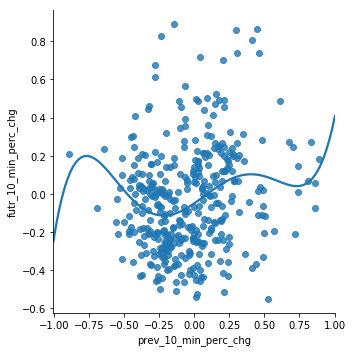

In [8]:
#sns.lmplot('prev_10_min_perc_chg', 'futr_10_min_perc_chg', data = features_df[-400:-20], fit_reg=True, order=5, ci=None)

In [9]:
features_df

,coin_partition,trade_date,trade_minute,trade_count,avg_price,avg_qty,avg_5_min_price,avg_5_min_qty,avg_5_min_trade_count,prev_min_perc_chg,...,prev_10_min_perc_chg,prev_5_min_rate_chg,prev_10_min_rate_chg,alt_prev_min_perc_chg,alt_prev_5_min_perc_chg,alt_prev_5_min_rate_chg,alt_prev_10_min_rate_chg,futr_min_perc_chg,futr_5_min_perc_chg,futr_10_min_perc_chg
0,trxeth,2018-01-01,25246080,47,0.000059,18966.042553,0.000059,18966.042553,47.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014776,-0.378247,-0.017643
1,trxeth,2018-01-01,25246081,48,0.000059,19044.416667,0.000059,19005.229610,47.500000,0.014776,...,0.000000,0.000000,0.000000,-0.037657,0.000000,0.000000,0.000000,-0.136973,-0.591329,0.519351
2,trxeth,2018-01-01,25246082,69,0.000059,21510.797101,0.000059,19840.418774,54.666667,-0.136973,...,0.000000,0.000000,0.000000,-0.025373,0.000000,0.000000,0.000000,-0.696358,-0.389388,1.106515
3,trxeth,2018-01-01,25246083,104,0.000059,21782.721154,0.000059,20325.994369,67.000000,-0.696358,...,0.000000,0.000000,0.000000,-0.148897,0.000000,0.000000,0.000000,-0.369630,0.082627,1.960595
4,trxeth,2018-01-01,25246084,74,0.000059,21077.729730,0.000059,20476.341441,68.400000,-0.369630,...,0.000000,0.000000,0.000000,-0.202087,0.000000,0.000000,0.000000,0.815746,0.747503,2.428942
5,trxeth,2018-01-01,25246085,64,0.000059,8691.218750,0.000059,18512.154326,67.666667,0.815746,...,0.000000,1.193993,0.000000,-0.236021,-0.648528,0.412507,0.000000,-0.199147,0.361973,1.526628
6,trxeth,2018-01-01,25246086,44,0.000059,26513.795455,0.000059,19770.113143,67.166667,-0.199147,...,0.000000,0.392182,0.000000,-0.350524,-0.959484,0.608959,0.000000,0.065891,1.117286,1.669492
7,trxeth,2018-01-01,25246087,31,0.000059,12042.967742,0.000059,18603.204989,64.333333,0.065891,...,0.000000,0.455279,0.000000,-0.062785,-0.996546,0.933761,0.000000,-0.225798,1.501750,1.700682
8,trxeth,2018-01-01,25246088,52,0.000059,22206.673077,0.000059,18719.184318,61.500000,-0.225798,...,0.000000,-0.308425,0.000000,0.064042,-0.785415,0.849457,0.000000,0.292242,1.876418,1.954042
9,trxeth,2018-01-01,25246089,106,0.000059,15623.160377,0.000059,17692.590855,61.833333,0.292242,...,0.000000,-0.455261,0.000000,0.072559,-0.512373,0.584933,0.000000,0.429955,1.668963,1.816133


## Standardize features

In [77]:
# PCA is impacted by scale
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit on training set only.
scaler.fit(X_train)
# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## PCA

In [79]:
from sklearn.decomposition import PCA
pca = PCA(n_components=25)
pca.fit(X_train)
print(sum(pca.explained_variance_ratio_)) 

0.8773786874088525


In [80]:
# Apply pca
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

## Model Selection

### Gradient Booster

In [81]:
clf = ensemble.GradientBoostingRegressor(n_estimators=500, learning_rate=.01, max_depth=6, 
                                                         max_features=.1, min_samples_leaf=1)

clf.fit(X_train, y_train)
print(f"R2: {r2_score(y_test, clf.predict(X_test))}")

R2: -0.004482034703992666


In [82]:
clf = ensemble.GradientBoostingRegressor(n_estimators=500, learning_rate=.02, max_depth=4, 
                                                         max_features=1, min_samples_leaf=9)
clf.fit(X_train, y_train)
print(f"R2: {r2_score(y_test, clf.predict(X_test))}")

R2: -0.009817097357763371


#### GB Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV 
param_grid = {'learning_rate': [0.1, 0.05, 0.02, 0.01], 
              'max_depth': [4, 6],     
              'min_samples_leaf': [1, 3, 5, 9, 17], 
              'max_features': [1.0, 0.3, 0.1]} 
est = ensemble.GradientBoostingRegressor(n_estimators=2000) 
gs_cv = GridSearchCV(est, param_grid).fit(X_train, y_train) # best hyperparameter setting 
gs_cv.best_params_

### Random Forest

In [ ]:
rf = ensemble.RandomForestRegressor(n_estimators=200)

rf.fit(X_train, y_train)
r2_score(y_test, rf.predict(X_test))

In [33]:
rf.feature_importances_

array([0.1173184 , 0.09437128, 0.12177482, 0.01972312, 0.02507456,
       0.08169567, 0.0262471 , 0.06485572, 0.0413153 , 0.03547063,
       0.08431119, 0.08253181, 0.07452237, 0.06892009, 0.06186795])

### XGBoost

In [17]:
model = xgb.XGBRegressor()

model.fit(X_train, y_train)
r2_score(y_test, model.predict(X_test))

0.2792954132729727

In [24]:
model = xgb.XGBRegressor()

model.fit(X_train, y_train)
r2_score(y_test, model.predict(X_test))

0.06505629769550314

In [53]:
model = xgb.XGBRegressor()

model.fit(X_train, y_train)
r2_score(y_test, model.predict(X_test))

0.05807539101141346

In [29]:
# Tuning
model = xgb.XGBRegressor(max_depth=5, n_estimators=100)

model.fit(X_train, y_train)
r2_score(y_test, model.predict(X_test))

0.2780616379164572

In [30]:
model.feature_importances_

array([0.01119942, 0.00830925, 0.02565029, 0.00686416, 0.00830925,
       0.00180636, 0.00541908, 0.0025289 , 0.00541908, 0.00541908,
       0.00289017, 0.0025289 , 0.        , 0.00397399, 0.00650289,
       0.00180636, 0.        , 0.        , 0.00180636, 0.        ,
       0.00397399, 0.00216763, 0.00325145, 0.00325145, 0.00216763,
       0.00072254, 0.        , 0.00072254, 0.        , 0.00578035,
       0.00361272, 0.00397399, 0.0050578 , 0.00144509, 0.00072254,
       0.00036127, 0.00216763, 0.        , 0.00433526, 0.00325145,
       0.00289017, 0.00216763, 0.00216763, 0.        , 0.00036127,
       0.00144509, 0.        , 0.00289017, 0.00469653, 0.00469653,
       0.00650289, 0.0025289 , 0.00072254, 0.00036127, 0.00180636,
       0.00036127, 0.00541908, 0.00975434, 0.00939306, 0.00614162,
       0.00180636, 0.        , 0.00036127, 0.00072254, 0.00036127,
       0.00469653, 0.00578035, 0.00614162, 0.00686416, 0.00072254,
       0.        , 0.00108382, 0.00289017, 0.        , 0.00614

### Linear Regression

In [51]:
lm = linear_model.LinearRegression()

lm.fit(X_train, y_train)
r2_score(y_test, lm.predict(X_test))

0.07036937416947908

In [28]:
clf = linear_model.RidgeCV(alphas=(.0001,.001,.01,.1,1,10), normalize=True)
#clf = linear_model.Ridge(alpha=10, normalize=True)
clf.fit(X_train, y_train)
print(r2_score(y_test, clf.predict(X_test)))

0.28113211854698006


In [31]:
import statsmodels.api as sm
X = sm.add_constant(X_train)
model = sm.OLS(y_train, X)
results = model.fit()

print(results.summary())

/Users/puter/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


                              OLS Regression Results                             
Dep. Variable:     futr_10_open_perc_chg   R-squared:                       0.258
Model:                               OLS   Adj. R-squared:                  0.257
Method:                    Least Squares   F-statistic:                     263.0
Date:                   Mon, 02 Jul 2018   Prob (F-statistic):               0.00
Time:                           22:16:52   Log-Likelihood:            -2.0341e+05
No. Observations:                 256766   AIC:                         4.075e+05
Df Residuals:                     256426   BIC:                         4.111e+05
Df Model:                            339                                         
Covariance Type:               nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

### Stochastic Gradient Descent Regression

In [35]:
# log data??
#y = np.log1p(y_train)
#y_ = np.log1p(y_test)

# transform and scale data
scaler = StandardScaler()
scaler.fit(X_train)
X = scaler.transform(X_train)
X_ = scaler.transform(X_test)

# train
sdg = linear_model.SGDRegressor(penalty='l2', alpha=0.15, max_iter=2000)
#sdg = linear_model.SGDRegressor(penalty='elasticnet', loss='epsilon_insensitive', alpha=0.15, max_iter=2000)

sdg.fit(X, y_train)
r2_score(y_test, sdg.predict(X_))

0.07099831746453267

In [36]:
# Grid search
from sklearn.model_selection import GridSearchCV 
param_grid = {'alpha': [0.2,0.15,0.1,0.01,0.001,0.0001,0.00001], 
              'max_iter': [50,200,600,1200,2000,6000,12000],     
              'loss': ['squared_loss','huber','epsilon_insensitive','squared_epsilon_insensitive'], 
              'penalty': ['l2','l1','elasticnet']} 
est = linear_model.SGDRegressor() 
sgd_cv = GridSearchCV(est, param_grid).fit(X, y) # best hyperparameter setting 
sgd_cv.best_params_

NameError: name 'y' is not defined

### Support Vector Machine (RBF Kernel)

In [ ]:
svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)

svr_rbf.fit(X_train, y_train)
r2_score(y_test, svr_rbf.predict(X_test))

### Polynomial Regression (with Ridge Regularization)

In [ ]:
%%time

poly = PolynomialFeatures(degree=3)
X = poly.fit_transform(X_train)
X_ = poly.fit_transform(X_test)
#clf = linear_model.LinearRegression(normalize=True)
clf = linear_model.RidgeCV(alphas=(.0001,.001,.01,.1,1,10), normalize=True)
#clf = linear_model.Ridge(alpha=10, normalize=True)
clf.fit(X, y_train)
print(r2_score(y_test, clf.predict(X_)))

# Simulate Return on Rolling Historical Data

In [ ]:
def simulate_return(model, df, feature_cols, target_col, start_days=1, training_mins=None, test_mins=1440):
    start_ix = 1440 * start_days
    results_df_list = []
    intervals = df[start_ix:].trade_date.nunique() * 1440 / test_mins
    for day in range(int(intervals)):
        end_train_ix = (day * test_mins) + start_ix
        end_test_ix = ((day * test_mins) + test_mins) + start_ix
        if training_mins:
            start_train_ix = end_train_ix - training_mins
            start_train_ix = 0 if start_train_ix < 0 else start_train_ix
            train_df = df.iloc[start_train_ix:end_train_ix,:]
        else:
            train_df = df.iloc[:end_train_ix,:]
        test_df = df.iloc[end_train_ix:end_test_ix,:]
        if test_df.empty:
            break
        if not pd.merge(train_df, test_df, on='trade_minute', how='inner').empty:
            print("The test and training sets overlap!!")
        X = train_df.loc[:,feature_cols]
        y = train_df.loc[:,target_col]
        X_sim = test_df.loc[:,feature_cols]
        
        if model == 'polynomial':
            poly = PolynomialFeatures(degree=3)
            X_ = poly.fit_transform(X)
            predict_ = poly.fit_transform(X_sim)
            clf = linear_model.RidgeCV(alphas=(.00001,.0001,.001,.01,.1,1,10), normalize=True)
            #clf = linear_model.Ridge(alpha=.01, normalize=True)
            #clf = linear_model.LinearRegression()
            clf.fit(X_, y)
            y_sim = clf.predict(predict_)
        else:
            model.fit(X, y)
            X_sim = test_df.loc[:,feature_cols]
            y_sim = model.predict(X_sim)
        y_act = test_df.loc[:,target_col]
        # 
        test_df.loc[:,'return'] = test_df[target_col] - .1  # how much for fees?
        test_df.loc[:,'predicted'] = y_sim
        results_df_list.append(test_df)
        
    results_df = pd.concat(results_df_list)
    
    # Identify best cut off
    optimal_buy_threshold = None
    best_return = 0
    num_trades = 0
    for thresh in list(np.arange(-4.0, 4.0, 0.1)):
        return_df = results_df.loc[results_df['predicted'] > thresh]
        if (return_df['return'].sum() > best_return) or (optimal_buy_threshold == None):
            optimal_buy_threshold = thresh
            best_return, num_trades = return_df['return'].sum(), len(return_df.index)
            
    # print/return
    results_df.loc[results_df['predicted'] >= optimal_buy_threshold, 'buy'] = 1 # reset buy threshold with optimum
    print(f"""Best Return at {optimal_buy_threshold}: {best_return}%
    Target: {target_col}; start_days: {start_days}; training_mins: {training_mins}; test_mins: {test_mins}
    Number of intervals simulating {intervals}
    Trades: {num_trades}""")
    daily_trades = results_df.loc[results_df['buy'] == 1].groupby('trade_date').agg({'return':'sum','trade_minute':'count'})
    return results_df, daily_trades


In [ ]:
X_train

In [ ]:
X_train

In [ ]:
X_test

In [ ]:
import seaborn as sns
#plt_df = pd.concat([X_train, y_train], axis=0)
sns.lmplot('prev_10_min_perc_chg', 'futr_10_min_perc_chg', data = features_df[-500:-20], fit_reg=True, order=6, ci=None)

### Simulate Polynomial Regression

In [ ]:
# find best train min threshold
feature_cols = ['avg_5_min_price','avg_5_min_qty','avg_5_min_trade_count','avg_qty','trade_count','avg_price',
                     'prev_min_perc_chg','prev_2_3_min_perc_chg','prev_3_4_min_perc_chg','prev_4_5_min_perc_chg',
                     'alt_prev_min_perc_chg','alt_prev_5_min_perc_chg',
                     'prev_5_min_perc_chg','prev_10_min_perc_chg']
target_col = 'futr_5_min_perc_chg'

results_df, daily_trades = simulate_return('polynomial', features_df, feature_cols, target_col, start_days=110, training_mins=360, test_mins=5)

In [ ]:
# find best train min threshold
feature_cols = ['avg_5_min_price','avg_5_min_qty','avg_5_min_trade_count','avg_qty','trade_count','avg_price',
                     'prev_min_perc_chg',#'prev_2_3_min_perc_chg','prev_3_4_min_perc_chg','prev_4_5_min_perc_chg',
                     'alt_prev_min_perc_chg','alt_prev_5_min_perc_chg',
                     'prev_5_min_perc_chg','prev_10_min_perc_chg']
target_col = 'futr_10_min_perc_chg'

results_df, daily_trades = simulate_return('polynomial', features_df, feature_cols, target_col, start_days=110, training_mins=120, test_mins=5)

In [ ]:
# Specific time period Feb 10th to 28th
feature_cols = ['avg_5_min_price','avg_5_min_qty','avg_5_min_trade_count','avg_qty','trade_count','avg_price',
                     'prev_min_perc_chg',#'prev_2_3_min_perc_chg','prev_3_4_min_perc_chg','prev_4_5_min_perc_chg',
                     'alt_prev_min_perc_chg','alt_prev_5_min_perc_chg',
                     'prev_5_min_perc_chg','prev_10_min_perc_chg']
target_col = 'futr_10_min_perc_chg'
data = features_df.loc[(features_df['trade_date'] > '2018-02-10') & (features_df['trade_date'] < '2018-02-27')]
results_df, daily_trades = simulate_return('polynomial', data, feature_cols, target_col, training_mins=120, test_mins=5)

In [ ]:
daily_trades

In [ ]:
results_df[results_df['predicted'] > .4]['return'].sum()
results_df.loc[results_df['predicted'] > .4].groupby('trade_date').agg({'return':'sum','trade_minute':'count'})

In [ ]:
# find best train min threshold
feature_cols = ['avg_5_min_price','avg_5_min_qty','avg_5_min_trade_count','avg_qty','trade_count','avg_price',
                 'prev_min_perc_chg','prev_2_3_min_perc_chg','prev_3_4_min_perc_chg','prev_4_5_min_perc_chg',
                 'alt_prev_min_perc_chg','alt_prev_5_min_perc_chg',
                 'prev_5_min_perc_chg','prev_10_min_perc_chg']
target_col = 'futr_5_min_perc_chg'

thresholds = list(range(60, 60*24, 120))
optimal = {}
for threshold in thresholds:
    results_df, daily_trades = simulate_return('polynomial', features_df, feature_cols, target_col, start_days=60, training_mins=threshold, test_mins=10)

In [ ]:
# Find best Feature set, training length, and testing length
feature_cols = ['avg_5_min_price','avg_5_min_qty','avg_5_min_trade_count','avg_qty','trade_count','avg_price',
                 'prev_min_perc_chg','prev_2_3_min_perc_chg','prev_3_4_min_perc_chg','prev_4_5_min_perc_chg',
                 'alt_prev_min_perc_chg','alt_prev_5_min_perc_chg',
                 'prev_5_min_perc_chg','prev_10_min_perc_chg']
target_col = 'futr_5_min_perc_chg'

thresholds = list(range(60, 60*24, 120)) # 1 hour - 24 hours
thresholds = list(range(60*24, 60*24*12, 60*24)) # 1 day - 12 days
optimal = {}
for threshold in thresholds:
    results_df, daily_trades = simulate_return('polynomial', features_df, feature_cols, target_col, start_days=60, training_mins=threshold, test_mins=10)

### Simulate Gradient Booster

In [ ]:
feature_cols = ['avg_5_min_price','avg_5_min_qty','avg_5_min_trade_count','avg_qty','trade_count','avg_price',
                 'prev_min_perc_chg','prev_2_3_min_perc_chg','prev_3_4_min_perc_chg','prev_4_5_min_perc_chg',
                 'prev_5_min_perc_chg','prev_10_min_perc_chg']
target_col = 'futr_10_min_perc_chg'
model = ensemble.GradientBoostingRegressor(n_estimators=2000, learning_rate=.02, max_depth=4, 
                                                         max_features=1, min_samples_leaf=9)
results_df, daily_trades = simulate_return(model, features_df, feature_cols, target_col, start_days=110)

In [ ]:
daily_trades

# Experiment with Classifiers

In [ ]:
# Where to put buy label threshold?
features_df.loc[(features_df['futr_5_min_perc_chg'] > 0) & (features_df['futr_5_min_perc_chg'] < 2),'futr_5_min_perc_chg'].hist()

In [ ]:
features_df['buy'] = 0
features_df.loc[features_df['futr_5_min_perc_chg'] > 1,'buy'] = 1
target_col = 'buy'

train_df = features_df.iloc[5000:,:]
test_df = features_df.iloc[0:5000,:]

# Upsample 'buy' class
df_majority = train_df[features_df.buy==0]
df_minority = train_df[features_df.buy==1]
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority.index),    # to match majority class
                                 random_state=123) # reproducible results
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

In [ ]:
X_train, X_test, y_train, y_test = df_upsampled[feature_cols], test_df[feature_cols], df_upsampled[target_col], test_df[target_col] 

In [ ]:
train_df['buy'].value_counts()

In [ ]:
rfc = ensemble.RandomForestClassifier(n_estimators=50)

rfc.fit(X_train, y_train)
print(classification_report(y_test, rfc.predict(X_test)))

In [ ]:
lgr = LogisticRegression()

lgr.fit(X_train, y_train)
print(classification_report(y_test, lgr.predict(X_test)))

In [ ]:
test_df['buy_pred'] = lgr.predict(X_test)
test_df[test_df['buy_pred'] == 1]['futr_5_min_perc_chg'].sum()

In [ ]:
test_df['futr_5_min_perc_chg'].sum()

### Simulate Classifer

In [ ]:
start_date = 1440*30
training_data_length = 1440*0 

feature_cols = ['avg_5_min_qty','avg_5_min_trade_count','avg_qty','trade_count',
                 'prev_min_perc_chg','prev_2_3_min_perc_chg','prev_3_4_min_perc_chg','prev_4_5_min_perc_chg',
                 'prev_5_min_perc_chg']
target_col = 'buy'

total_return = []
trades = []
results_df_list = []

print(f"Number of days simulating {features_df[start_date:].trade_date.nunique()}")
for day in range(features_df.trade_date.nunique()):
    # Reset
    end_train_period = ((day + 2) * 1440) + start_date
    start_train_period = end_train_period - training_data_length
    end_test_period = ((day + 3) * 1440) + start_date
    train_df = features_df.iloc[:end_train_period,:]
    test_df = features_df.iloc[end_train_period:end_test_period,:]
    
    # Upsample 'buy' class
    df_majority = train_df[features_df.buy==0]
    df_minority = train_df[features_df.buy==1]
    df_minority_upsampled = resample(df_minority, 
                                     replace=True,     # sample with replacement
                                     n_samples=len(df_majority.index),    # to match majority class
                                     random_state=123) # reproducible results
    df_upsampled = pd.concat([df_majority, df_minority_upsampled])
    
    if test_df.empty:
        break
    X = df_upsampled[feature_cols]
    y = df_upsampled[target_col]
    #
    model = LogisticRegression()
    model.fit(X, y)
    #
    X_sim = test_df[feature_cols]
    y_act = test_df['futr_5_min_perc_chg']
    y_sim = model.predict(X_sim)
    #
    test_df['return'] = test_df['futr_5_min_perc_chg'] - .1
    test_df['predicted'] = y_sim
    results_df_list.append(test_df)
    # print
    sim_buy_df = test_df.loc[test_df['predicted'] == 1]
    total_return.append(sim_buy_df['return'].sum())
    trades = trades + list(sim_buy_df['return'])
print(sum(total_return))
print(len(trades))
results_df = pd.concat(results_df_list)

In [ ]:
gbc = ensemble.GradientBoostingClassifier(n_estimators=50)

gbc.fit(X_train, y_train)
print(classification_report(y_test, gbc.predict(X_test)))

In [ ]:
sv = SVC(kernel='linear', 
            class_weight='balanced', # penalize
            probability=True)

sv.fit(X_train, y_train)
print(classification_report(y_test, sv.predict(X_test)))

## Simulate Predictions on Custom Time Period

In [ ]:
train_df = features_df.iloc[5000:,:]
test_df = features_df.iloc[0:5000,:]

X = train_df[['avg_5_min_qty','avg_5_min_price','avg_5_min_trade_count','avg_price','prev_min_perc_chg','prev_5_min_perc_chg']]
y = train_df['futr_5_min_perc_chg']

model = linear_model.LinearRegression()
model.fit(X, y)

In [ ]:
X_sim = test_df[['avg_5_min_qty','avg_5_min_price','avg_5_min_trade_count','avg_price','prev_min_perc_chg','prev_5_min_perc_chg']]
y_act = test_df['futr_5_min_perc_chg']
y_sim = model.predict(X_sim)

In [ ]:
sim_df = pd.DataFrame(data={'actual':y_act, 'predicted':y_sim})
sim_df.loc[sim_df['predicted'] > .5, 'buy'] = 1
sim_df.head(20)

In [ ]:
sim_buy_df = sim_df.loc[sim_df['buy'] == 1]
sim_buy_df['return'] = sim_buy_df['actual'] - .1 # 50 cents is roughly the cost to trade 1 $500 etherium
sim_buy_df

In [ ]:
sim_buy_df['return'].sum()

## Simulate Predictions Across All Days

In [ ]:
train_df = features_df.iloc[1440:,:]
test_df = features_df.iloc[0:1440,:]

total_return = []
print(f"Number of days simulating {features_df.trade_date.nunique()}")
for day in range(features_df.trade_date.nunique()):
    X = train_df[['avg_5_min_qty','avg_5_min_price','avg_5_min_trade_count','avg_price','prev_min_perc_chg','prev_5_min_perc_chg']]
    y = train_df['futr_5_min_perc_chg']
    #
    model = linear_model.LinearRegression()
    model.fit(X, y)
    #
    X_sim = test_df[['avg_5_min_qty','avg_5_min_price','avg_5_min_trade_count','avg_price','prev_min_perc_chg','prev_5_min_perc_chg']]
    y_act = test_df['futr_5_min_perc_chg']
    y_sim = model.predict(X_sim)
    #
    sim_df = pd.DataFrame(data={'actual':y_act, 'predicted':y_sim})
    sim_df.loc[sim_df['predicted'] > .5, 'buy'] = 1
    #
    sim_buy_df = sim_df.loc[sim_df['buy'] == 1]
    sim_buy_df['return'] = sim_buy_df['actual'] - .1 
    total_return.append(sim_buy_df['return'].sum())
    # Reset
    train_df_1 = features_df.iloc[:(day+2)*1440,:]
    train_df_2 = features_df.iloc[(day+3)*1440:,:]
    train_df = pd.concat([train_df_1, train_df_2])
    test_df = features_df.iloc[(day+2)*1440:(day+3)*1440,:]
    if test_df.empty:
        break

In [ ]:
total_return

In [ ]:
sum(total_return)

In [ ]:
pd.merge(train_df, test_df, on=['trade_minute'],how='inner')

## Validation

In [ ]:
features_df.loc[start_date:,'futr_5_min_perc_chg'].sum()

In [ ]:
import pandas_profiling
pandas_profiling.ProfileReport(sim_buy_df[['predicted','return']])